In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, keras.backend as K, tensorflow as tf, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from numpy.testing import assert_almost_equal
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "1"
%matplotlib inline
temp_font_size = 20
temp_tick_size = 35
from temp_tf_load import *
lag_time = 100
def get_autocorr(x_list, lag_time):
    return np.corrcoef(np.array([x_list[0:len(x_list) - lag_time], x_list[lag_time:len(x_list)]]))[0, 1]

Using TensorFlow backend.


In [2]:
def potential(x, y):
    radius = 0.8
    dr = 0.05
    r = np.sqrt(x**2 + y ** 2)
    angle = np.arccos(x / r) * np.sign(y) % (2 * np.pi)
    result = 2.5 + 9 * np.abs(r - radius) ** 2
    result[np.abs(r- radius) < dr] = 0
    potential_heights = [0.5, 1.3, 1, 8]
    potential_locations = [0.25, 0.5, 0.75, 0]
    potential_widths = [0.25, 0.25, 0.25, 0.05]
    potential_r_widths = [0.1, 0.1, 0.1, 0.1]
    result[(np.abs(angle - 0 * 2 * np.pi) < potential_widths[-1]) & (r > 0.4)] = potential_heights[-1]
    result[(np.abs(angle - 1 * 2 * np.pi) < potential_widths[-1]) & (r > 0.4)] = potential_heights[-1]
    for item in range(len(potential_heights)):
        result[(np.abs(r- radius) < dr) & (
            np.abs(angle - potential_locations[item] * 2 * np.pi) < potential_widths[item])] = potential_heights[item]
    return 10 * result, potential_locations, potential_heights

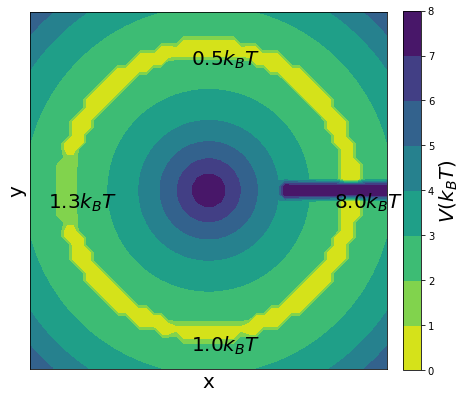

In [3]:
# define potential
bins = 50
temp_font_size = 20
kT = 10.0
xx, yy = np.meshgrid(np.linspace(-1,1, bins), np.linspace(-1, 1, bins))
VV, potential_locations, potential_heights = potential(xx, yy)
xy_list = np.concatenate([xx.reshape(bins ** 2, 1), yy.reshape(bins ** 2, 1)], axis=-1)
fig, ax = plt.subplots()
c_levels = np.arange(0, 8.5, 1)
im = ax.contourf(xx, yy, VV / kT,c_levels, cmap='viridis_r')
ax.set_xlabel('x', fontsize = temp_font_size); ax.set_ylabel('y', fontsize = temp_font_size)
ax.set_aspect(1.0)
for item_1, item_2 in zip(potential_locations, potential_heights):
    ax.text(0.8 * np.cos(2 * np.pi * item_1) - 0.1, 
            0.8 * np.sin(2 * np.pi * item_1) - 0.1, 
            "$%.1f k_BT$" % (item_2 ), fontsize = temp_font_size)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(im, ax = ax, fraction=0.046, pad=0.04)
cbar.set_label('$V(k_BT)$', fontsize = temp_font_size)
fig.set_size_inches(7, 7)

In [4]:
def get_transition_matrix(VV, kT = 60.0):
    num_points = len(VV.flatten())
    temp_VV = VV / kT
    num_rows, num_cols = temp_VV.shape
    transition = np.zeros((num_points, num_points))
    for item_1 in range(num_rows):
        for item_2 in range(num_cols):
            p_left = np.exp(-(temp_VV[item_1][item_2 - 1] - temp_VV[item_1][item_2])) if item_2 != 0 else 0
            p_right = np.exp(-(temp_VV[item_1][item_2 + 1] - temp_VV[item_1][item_2])) if item_2 != num_cols - 1 else 0
            p_down = np.exp(-(temp_VV[item_1 - 1][item_2] - temp_VV[item_1][item_2])) if item_1 != 0 else 0
            p_up = np.exp(-(temp_VV[item_1 + 1][item_2] - temp_VV[item_1][item_2])) if item_1 != num_rows - 1 else 0
            p_sum = p_left + 1 + p_right + p_up + p_down
            current_index = item_1 * num_cols + item_2
            transition[current_index - 1][current_index] = p_left / p_sum
            transition[current_index][current_index] = 1 / p_sum
            transition[(current_index + 1) % num_points][current_index] = p_right / p_sum
            transition[(current_index + num_cols) % num_points][current_index] = p_up / p_sum
            transition[(current_index - num_cols) % num_points][current_index] = p_down / p_sum
    assert_almost_equal(transition.sum(axis=0), np.ones(num_points), decimal=2)
    return transition

In [5]:
# get transition matrix of lag 1 and lag 100
transition_1 = get_transition_matrix(VV, kT=kT)
lag_time = 100
transition = np.linalg.matrix_power(transition_1, lag_time)

In [6]:
def get_sorted_eigen_values_vecs(matrix):
    eigenValues, eigenVectors = np.linalg.eig(matrix)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors.T[idx]
    return eigenValues, eigenVectors

def inner_prod(xx, yy, equi_dist):
    return np.sum(xx * yy * equi_dist)

def normalize_state(state, equi_dist):
    return state / np.sqrt(inner_prod(state, state, equi_dist))

In [7]:
# get eigenvalues, eigenstates, equilibrium distribution
eigenValues, eigenVectors = get_sorted_eigen_values_vecs(transition)
equi_dist = np.real_if_close(eigenVectors[0] / np.sum(eigenVectors[0]))
time_scales = - lag_time / np.log(eigenValues)
eigenstates = [item / equi_dist for item in eigenVectors]
eigenstates = [np.real_if_close(normalize_state(item, equi_dist)) for item in eigenstates]   # normalization

In [8]:
def plot_state_with_potential_contour(state, VV, bins, fig, levels=None, ax=None, title=None, 
                                      color_label = None, c_lim=None, xlabel='x', ylabel='y', include_cbar=True):
    im = ax.contourf(xx, yy, state.reshape(bins, bins), levels=levels, cmap='viridis_r' )
    ax.contour(xx, yy, VV / kT, c_levels, cmap='Greys')
    ax.set_xlabel(xlabel, fontsize=temp_font_size)
    ax.set_ylabel(ylabel, fontsize=temp_font_size)
    if not title is None:
        ax.set_title(title, fontsize = temp_font_size)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    if include_cbar:
        cbar = fig.colorbar(im, ax=ax)
        if not color_label is None: cbar.set_label(color_label, fontsize=temp_font_size)
    return ax

def plot_state_with_potential_contour_with_coeff(state, VV, bins, fig, index, timescale=None,
                                                levels=None, ax=None, title=None, 
                                      color_label = None, c_lim=None, xlabel='x', ylabel='y', include_cbar=True):
    plot_state_with_potential_contour(state, VV, bins, fig, levels=levels, ax=ax, title=title,
                                      color_label=color_label, c_lim=c_lim, xlabel=xlabel, ylabel=ylabel, 
                                      include_cbar=include_cbar
                                     )
    coeff = get_decompose_coeff(state, eigenstates[:5], equi_dist)
    return

In [9]:
# theoretical timescales
th_timescales = [-lag_time / np.log(eigenValues[item + 1]) for item in range(4)]

/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


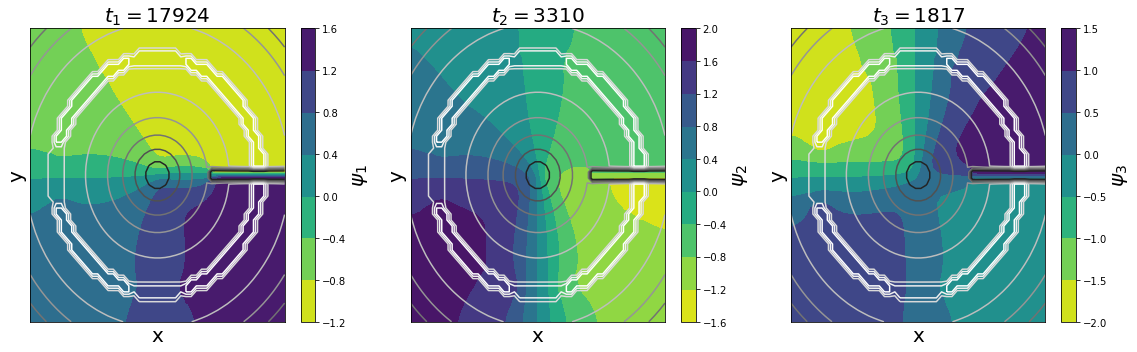

In [10]:
# plot first three theoretical eigenstates with timescales
num_eig_states = 3
fig, axes = plt.subplots(1, num_eig_states)
for item in range(num_eig_states):
    plot_state_with_potential_contour(eigenstates[item+1], VV, bins, fig, ax=axes[item], 
                                      title="$t_%d = %d$" % (item + 1, th_timescales[item]),
                                      color_label = "$\psi_%d$" % (item + 1)
                                     )
fig.set_size_inches(5 * num_eig_states + 1,5)
fig.tight_layout()

In [11]:
def run_markov_simulation(transition, num_cols, xy_list, start_point = None, steps = 1e6):
    num_states = len(transition)
    if start_point is None: 
        point = np.random.randint(num_states)
    else: point = start_point
    traj = [point]
    for _ in range(int(steps - 1)):
        rand_num = np.random.rand()
        if rand_num < transition[(point - 1) % num_states][point]:
            point -= 1
        elif rand_num < transition[(point - 1) % num_states][point] + transition[(point + 1) % num_states][point]:
            point = (point + 1) % num_states
        elif rand_num < transition[(point - 1) % num_states][point] + transition[(point + 1) % num_states][point] + transition[(point - num_cols) % num_states][point]:
            point = (point - num_cols) % num_states
        elif rand_num < transition[(point - 1) % num_states][point] + transition[(point + 1) % num_states][point] + transition[(point - num_cols) % num_states][point] + transition[(point + num_cols) % num_states][point]:
            point = (point + num_cols) % num_states
        traj.append(point)
    traj = np.array(traj)
    return traj, xy_list[traj]

def traj_to_bin(traj, x_list):
    bin_list = np.zeros(len(traj), dtype=np.int)
    for item in range(len(x_list)):
        bin_list[np.logical_and((traj == xy_list[item])[:, 0], (traj == xy_list[item])[:, 1])] = item
    return bin_list

In [12]:
# here we load pre-simulated data, feel free to generate new data with first line
traj_bins, traj = run_markov_simulation(transition_1, bins, xy_list, steps=5e6)
test_bins, test_traj = run_markov_simulation(transition_1, bins, xy_list, steps=1e6)  # generate test_trajectory as well

In [13]:
def remove_component_from_state(state, equi_dist, components):
    result = state
    for item in components:
        result = result - item * np.sum(result * equi_dist * item) / np.sum(item * equi_dist * item)
        assert (np.abs(np.sum(result * item * equi_dist)) < 1e-4), np.abs(np.sum(result * item * equi_dist))
    return result

def get_decompose_coeff(state, eigenstates, equi_dist):
    return ['%.03f' % inner_prod(state, item, equi_dist) for item in eigenstates]

## kTICA

In [14]:
from temp_ktica import *
from sklearn.model_selection import train_test_split, KFold
sigma_list = [0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5]
n_lm_list = [50, 100, 300, 500, 800, 1000]

In [15]:
# it takes very long time to get all landmarks (even with subsampling), therefore we load pre-computed landmarks:

# def get_landmarks(n_landmarks):
#     kmeans = KMeans(init='k-means++', n_clusters=n_landmarks, n_init=10)
#     kmeans.fit(traj[::50])
#     return kmeans.cluster_centers_

# landmarks_list = [get_landmarks(item) for item in n_lm_list]
# np.save('/home/kengyangyao/data/hde_paper_results/ring_landmarks.npy', landmarks_list)
landmarks_list = np.load('/home/kengyangyao/data/hde_paper_results/ring_landmarks.npy')

In [16]:
skip = 10
def get_ktica_results(sigma, landmarks, shrinkage=None):
    ktica = Kernel_tica(3, lag_time=lag_time // skip, gamma=1.0 / (2 * sigma* sigma), 
                        n_components_nystroem=len(landmarks), landmarks = landmarks, shrinkage=shrinkage)
    ktica.fit([traj[::skip]])
    proj_0 = ktica.transform([xy_list])[0]
    fig, axes = plt.subplots(1, 3)
    for item in range(3):
        proj_0[:, item] = normalize_state(proj_0[:, item], equi_dist)
        plot_state_with_potential_contour_with_coeff(proj_0[:, item], VV, bins, fig=fig, ax=axes[item], index=item+1, 
                                                     timescale= ktica._tica.timescales[item] * skip,
                                                    color_label = "$\psi_%d$" % (item + 1))
    fig.set_size_inches(16, 5)
    temp_coords = ktica.transform([test_traj[::skip]])[0]
    test_vamp = np.sum([
        get_autocorr(temp_coords[:, item], lag_time=lag_time // skip) ** 2 for item in range(3)])
    return fig, ktica, test_vamp, proj_0[:, 0]

using landmarks


100%|██████████| 15/15 [00:49<00:00,  3.26s/it]                       


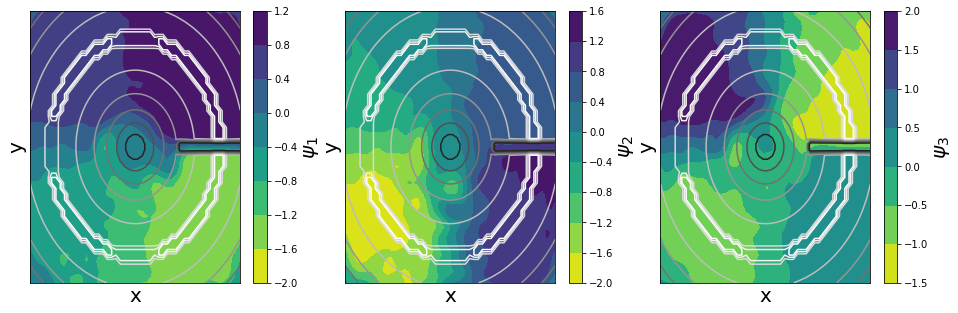

In [17]:
# kTICA result with optimal sigma = 0.1
fig, ktica, test_vamp, _ = get_ktica_results(0.1, landmarks=landmarks_list[-1])

## HDE

In [18]:
sys.path.append('../../hde_vac/')
from hde import HDE

In [19]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
hde = HDE(2, n_components=3, lag_time=lag_time, dropout_rate=0, batch_size=500000, n_epochs=100, hidden_size=100,
          validation_split=0., batch_normalization=True, learning_rate = 0.005,
          callbacks=[earlyStopping])

In [20]:
# hde.r_degree = 10   # pretraining
# hde.fit(traj)    
# hde._recompile = True
hde.r_degree = 2
hde.fit(traj)

Train on 4999900 samples, validate on 0 samples
Epoch 1/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.2554
Epoch 2/100


/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4999900/4999900 [==============================] - 6s 1us/step - loss: -3.3419
Epoch 3/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.6715
Epoch 4/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7448
Epoch 5/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7676
Epoch 6/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7778
Epoch 7/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7851
Epoch 8/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7907
Epoch 9/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7947
Epoch 10/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.7979
Epoch 11/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.8004
Epoch 12/100
4999900/4999900 [==============================] - 6s 1us/step - loss: -3.8025
Epoch 13

HDE(activation=None, batch_normalization=True, batch_size=500000,
  callbacks=[<keras.callbacks.EarlyStopping object at 0x7f472c10d5f8>],
  dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=2,
  l2_regularization=0.0, lag_time=100, latent_space_noise=0,
  learning_rate=0.005, n_components=3, n_epochs=100, validation_split=0.0,
  verbose=True)

In [21]:
CVs_state_list = hde.transform(xy_list).T

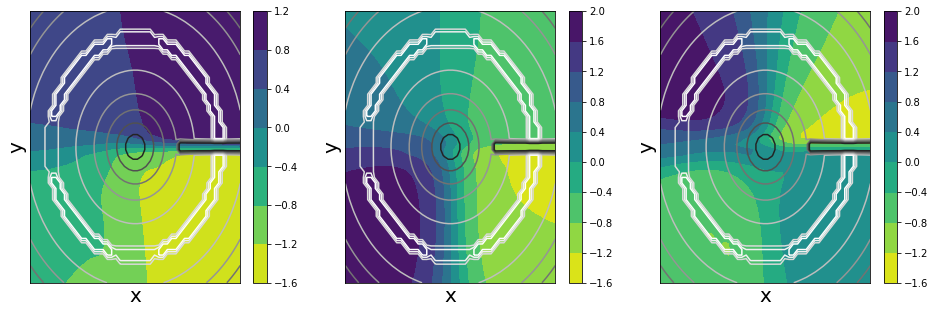

In [22]:
fig, axes = plt.subplots(1, 3)
for item in range(3):
    plot_state_with_potential_contour_with_coeff(CVs_state_list[item], VV, bins, fig=fig, ax=axes[item], index=item + 1, 
                                                 timescale=hde.timescales_[item])

fig.set_size_inches(16, 5)

In [23]:
hde_coords = hde.transform(xy_list)
hde_timescales = hde.timescales_
ktica_coords = ktica.transform([xy_list])[0]
ktica_timescales = ktica._tica.timescales * 10      # because we subsample in KTICA
th_eigenstates = np.array(eigenstates[1:4]).T
th_timescales = th_timescales

/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


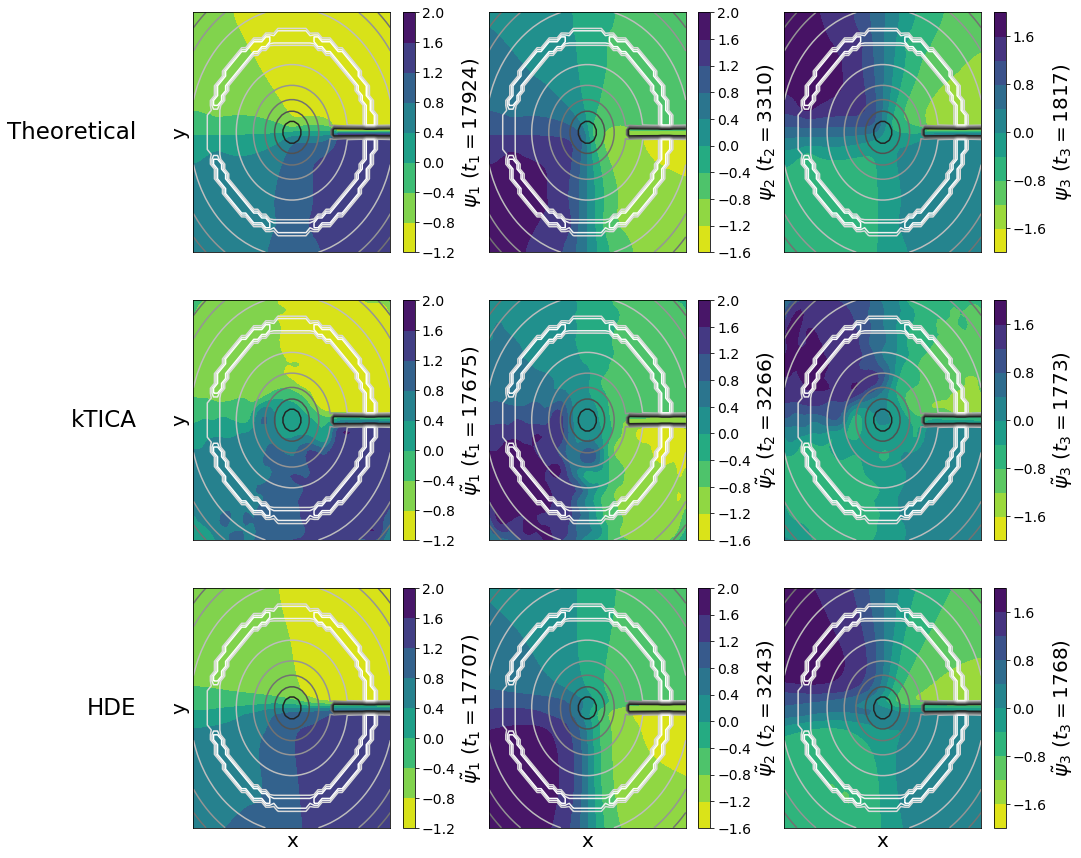

In [24]:
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(3, 3)
coords_list = [th_eigenstates, ktica_coords, hde_coords]
timescales_list = [th_timescales,ktica_timescales, hde_timescales]
levels_list = [np.arange(-1.2, 2.1, 0.4), np.arange(-1.6, 2.2, 0.4), np.arange(-2.0, 2.1, 0.4)]
cbar_labels = [['$\psi_%d\ (t_%d = %d)$' % (item, item, th_timescales[item - 1]) for item in range(1, 4)],
               ['$\\tilde{\psi}_%d\ (t_%d = %d)$' % (item, item, ktica_timescales[item-1]) for item in range(1, 4)],
               ['$\\tilde{\psi}_%d\ (t_%d = %d)$' % (item, item, hde_timescales[item-1]) for item in range(1, 4)]]
row_label_list = ['Theoretical', 'kTICA', 'HDE']

for index_row in range(3):
    for index_col in range(3):
        state = coords_list[index_row][:, index_col]
        state *= np.sign(np.sum(state))
        xlabel = 'x' if index_row == 2 else ""
        ylabel = 'y' if index_col == 0 else ""
        plot_state_with_potential_contour(state, VV, bins, fig, ax=axes[index_row, index_col],  
                                          color_label=cbar_labels[index_row][index_col],
                                          levels=levels_list[index_col], xlabel=xlabel, ylabel=ylabel)
pad = 30 
for ax, row in zip(axes[:, 0], row_label_list):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=23)
fig.set_size_inches(15, 15)